used u-net and
conditional generation

In [1]:
!pip install labml_helpers --quiet
!pip install labml_nn --quiet
!pip install torch-summary --quiet

In [34]:
import math
import random
import os
from typing import Optional, Tuple, Union, List

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
import torch.utils.data

from labml_helpers.module import Module
from labml_nn.diffusion.ddpm.utils import gather

import gc

---

In [3]:
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 123
BATCH_SIZE, DEVICE, SEED

(64, device(type='cuda'), 123)

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

### Data-Preparation

In [5]:
# Padding is necesarry to make 28x28 images to 32x32 which can then be input into the diffuser's U-Net
# %%capture cap --no-stderr

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Pad(2)])

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = transforms)

print(" --- DONE ---")

100%|██████████| 26421880/26421880 [00:01<00:00, 16121333.10it/s]


Extracting ./data/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269005.86it/s]


Extracting ./data/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5074031.50it/s]


Extracting ./data/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9231413.85it/s]


Extracting ./data/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 15880465.11it/s]


Extracting ./data/valid/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/valid/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271563.98it/s]


Extracting ./data/valid/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/valid/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5043541.80it/s]


Extracting ./data/valid/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/valid/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23118069.58it/s]

Extracting ./data/valid/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/valid/FashionMNIST/raw

 --- DONE ---


In [6]:
train_dl = torch.utils.data.DataLoader(dataset = train_ds,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                                num_workers = 2,
                                                prefetch_factor=2,
                                                drop_last = True,
                                                pin_memory=True)
valid_dl = torch.utils.data.DataLoader(dataset = valid_ds,
                                               batch_size = BATCH_SIZE,
                                               shuffle = False,
                                                num_workers = 2,
                                                prefetch_factor=2,
                                               drop_last = False)

In [7]:
x, y = next(iter(train_dl))
x, y = x.to(DEVICE), y.to(DEVICE)
x.device, x.shape, y.shape

(device(type='cuda', index=0), torch.Size([64, 1, 32, 32]), torch.Size([64]))

---

### utility functions

In [8]:
def plot_images(batch, idxToDsiplay=None, display=(1, 8), cmap='gray'):
    if not isinstance(batch,(np.ndarray)):
        batch = batch.detach().cpu()
    if len(batch.shape)==3:
        if not isinstance(batch,(np.ndarray)):
            batch = batch.unsqueeze(1)
        else:
            batch = np.expand_dims(batch, 1)
    fig = plt.figure()
    rng = np.random.default_rng()
    if idxToDsiplay is None:
        idxToDsiplay = rng.choice(batch.shape[0], size=min(batch.shape[0], display[0]*display[1]), replace=batch.shape[0]<(display[0]*display[1]))
    for i, idx in enumerate(idxToDsiplay):
        ax = fig.add_subplot(display[0], display[1], i+1)
        if not isinstance(batch,(np.ndarray)):
            ax.imshow(batch[idx].permute(1, 2, 0), cmap=cmap)
        else:
            ax.imshow(batch[idx].transpose(1, 2, 0), cmap=cmap)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    plt.subplots_adjust(wspace=0.08, hspace=-0.65)
    plt.show()
    return idxToDsiplay

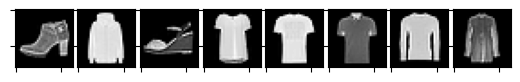

array([28, 18,  6, 10, 44, 42,  8, 45])

In [9]:
plot_images(x)

### Model

#### model-utility

In [10]:
class Swish(Module):
    """
    Swish actiavation function
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

In [11]:
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

In [12]:
class ResidualBlock(Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

In [13]:
class AttentionBlock(Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res

In [14]:
class DownBlock(Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

#### u-net

In [15]:
class UNet(Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

### Diffusion Process

In [16]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        * `n_steps` is $t$
        * `device` is the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model
        self.device = device

        # Create $\beta_1, \dots, \beta_T$ linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # $\alpha_t = 1 - \beta_t$
        self.alpha = 1. - self.beta
        # $\bar\alpha_t = \prod_{s=1}^t \alpha_s$
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # $T$
        self.n_steps = n_steps
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        #### Get $q(x_t|x_0)$ distribution

        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # [gather](utils.html) $\alpha_t$ and compute $\sqrt{\bar\alpha_t} x_0$
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        # $(1-\bar\alpha_t) \mathbf{I}$
        var = 1 - gather(self.alpha_bar, t)
        #
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        #### Sample from $q(x_t|x_0)$

        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if eps is None:
            eps = torch.randn_like(x0)

        # get $q(x_t|x_0)$
        mean, var = self.q_xt_x0(x0, t)
        # Sample from $q(x_t|x_0)$
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

        \begin{align}
        \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \textcolor{lightgreen}{\mu_\theta}(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
        \end{align}
        """

        # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
        eps_theta = self.eps_model(xt, t)
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
        # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
        #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # $\sigma^2$
        var = gather(self.sigma2, t)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

    def sample(self, n_samples, image_channels, image_size):
        """
        ### Sample images
        """
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn([n_samples, image_channels, image_size, image_size],
                            device=self.device)

            # Remove noise for $T$ steps
            for t_ in range(self.n_steps):
                # $t$
                t = self.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.p_sample(x, x.new_full((n_samples,), t, dtype=torch.long))

            # Log samples
            return x

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """
        #### Simplified Loss

        $$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
        \epsilon - \textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
        \bigg\Vert^2 \Bigg]$$
        """
        # Get batch size
        batch_size = x0.shape[0]
        # Get random $t$ for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample $x_t$ for $q(x_t|x_0)$
        xt = self.q_sample(x0, t, eps=noise)
        # Get $\textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)$
        eps_theta = self.eps_model(xt, t)

        # MSE loss
        return F.mse_loss(noise, eps_theta)

#### -

In [17]:
# class Sampler:
#     """
#     ## Sampler class
#     """
#     def __init__(self, diffusion: DenoiseDiffusion, image_channels: int, image_size: int, device: torch.device):
#         """
#         * `diffusion` is the `DenoiseDiffusion` instance
#         * `image_channels` is the number of channels in the image
#         * `image_size` is the image size
#         * `device` is the device of the model
#         """
#         self.device = device
#         self.image_size = image_size
#         self.image_channels = image_channels
#         self.diffusion = diffusion

#         # $T$
#         self.n_steps = diffusion.n_steps
#         # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
#         self.eps_model = diffusion.eps_model
#         # $\beta_t$
#         self.beta = diffusion.beta
#         # $\alpha_t$
#         self.alpha = diffusion.alpha
#         # $\bar\alpha_t$
#         self.alpha_bar = diffusion.alpha_bar
#         # $\bar\alpha_{t-1}$
#         alpha_bar_tm1 = torch.cat([self.alpha_bar.new_ones((1,)), self.alpha_bar[:-1]])

#         # To calculate
#         #
#         # \begin{align}
#         # q(x_{t-1}|x_t, x_0) &= \mathcal{N} \Big(x_{t-1}; \tilde\mu_t(x_t, x_0), \tilde\beta_t \mathbf{I} \Big) \\
#         # \tilde\mu_t(x_t, x_0) &= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}x_0
#         #                          + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1})}{1-\bar\alpha_t}x_t \\
#         # \tilde\beta_t &= \frac{1 - \bar\alpha_{t-1}}{a}
#         # \end{align}

#         # $\tilde\beta_t$
#         self.beta_tilde = self.beta * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
#         # $$\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}$$
#         self.mu_tilde_coef1 = self.beta * (alpha_bar_tm1 ** 0.5) / (1 - self.alpha_bar)
#         # $$\frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1}}{1-\bar\alpha_t}$$
#         self.mu_tilde_coef2 = (self.alpha ** 0.5) * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
#         # $\sigma^2 = \beta$
#         self.sigma2 = self.beta

#     # def show_image(self, img, title=""):
#     #     """Helper function to display an image"""
#     #     img = img.clip(0, 1)
#     #     img = img.cpu().numpy()
#     #     plt.imshow(img.transpose(1, 2, 0))
#     #     plt.title(title)
#     #     plt.show()

#     # def make_video(self, frames, path="video.mp4"):
#     #     """Helper function to create a video"""
#     #     import imageio
#     #     # 20 second video
#     #     writer = imageio.get_writer(path, fps=len(frames) // 20)
#     #     # Add each image
#     #     for f in frames:
#     #         f = f.clip(0, 1)
#     #         f = to_pil_image(resize(f, [368, 368]))
#     #         writer.append_data(np.array(f))
#     #     #
#     #     writer.close()

#     # def sample_animation(self, n_frames: int = 1000, create_video: bool = True):
#     #     """
#     #     #### Sample an image step-by-step using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

#     #     We sample an image step-by-step using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$ and at each step
#     #     show the estimate
#     #     $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
#     #      \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
#     #     """

#     #     # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
#     #     xt = torch.randn([1, self.image_channels, self.image_size, self.image_size], device=self.device)

#     #     # Interval to log $\hat{x}_0$
#     #     interval = self.n_steps // n_frames
#     #     # Frames for video
#     #     frames = []
#     #     # Sample $T$ steps
#     #     for t_inv in monit.iterate('Denoise', self.n_steps):
#     #         # $t$
#     #         t_ = self.n_steps - t_inv - 1
#     #         # $t$ in a tensor
#     #         t = xt.new_full((1,), t_, dtype=torch.long)
#     #         # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
#     #         eps_theta = self.eps_model(xt, t)
#     #         if t_ % interval == 0:
#     #             # Get $\hat{x}_0$ and add to frames
#     #             x0 = self.p_x0(xt, t, eps_theta)
#     #             frames.append(x0[0])
#     #             if not create_video:
#     #                 self.show_image(x0[0], f"{t_}")
#     #         # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
#     #         xt = self.p_sample(xt, t, eps_theta)

#     #     # Make video
#     #     if create_video:
#     #         self.make_video(frames)

#     def interpolate(self, x1: torch.Tensor, x2: torch.Tensor, lambda_: float, t_: int = 100):
#         """
#         #### Interpolate two images $x_0$ and $x'_0$

#         We get $x_t \sim q(x_t|x_0)$ and $x'_t \sim q(x'_t|x_0)$.

#         Then interpolate to
#          $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$

#         Then get
#          $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$

#         * `x1` is $x_0$
#         * `x2` is $x'_0$
#         * `lambda_` is $\lambda$
#         * `t_` is $t$
#         """

#         # Number of samples
#         n_samples = x1.shape[0]
#         # $t$ tensor
#         t = torch.full((n_samples,), t_, device=self.device)
#         # $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
#         xt = (1 - lambda_) * self.diffusion.q_sample(x1, t) + lambda_ * self.diffusion.q_sample(x2, t)

#         # $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
#         return self._sample_x0(xt, t_)

#     # def interpolate_animate(self, x1: torch.Tensor, x2: torch.Tensor, n_frames: int = 100, t_: int = 100,
#     #                         create_video=True):
#     #     """
#     #     #### Interpolate two images $x_0$ and $x'_0$ and make a video

#     #     * `x1` is $x_0$
#     #     * `x2` is $x'_0$
#     #     * `n_frames` is the number of frames for the image
#     #     * `t_` is $t$
#     #     * `create_video` specifies whether to make a video or to show each frame
#     #     """

#     #     # Show original images
#     #     self.show_image(x1, "x1")
#     #     self.show_image(x2, "x2")
#     #     # Add batch dimension
#     #     x1 = x1[None, :, :, :]
#     #     x2 = x2[None, :, :, :]
#     #     # $t$ tensor
#     #     t = torch.full((1,), t_, device=self.device)
#     #     # $x_t \sim q(x_t|x_0)$
#     #     x1t = self.diffusion.q_sample(x1, t)
#     #     # $x'_t \sim q(x'_t|x_0)$
#     #     x2t = self.diffusion.q_sample(x2, t)

#     #     frames = []
#     #     # Get frames with different $\lambda$
#     #     for i in monit.iterate('Interpolate', n_frames + 1, is_children_silent=True):
#     #         # $\lambda$
#     #         lambda_ = i / n_frames
#     #         # $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
#     #         xt = (1 - lambda_) * x1t + lambda_ * x2t
#     #         # $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
#     #         x0 = self._sample_x0(xt, t_)
#     #         # Add to frames
#     #         frames.append(x0[0])
#     #         # Show frame
#     #         if not create_video:
#     #             self.show_image(x0[0], f"{lambda_ :.2f}")

#     #     # Make video
#     #     if create_video:
#     #         self.make_video(frames)

#     def _sample_x0(self, xt: torch.Tensor, n_steps: int):
#         """
#         #### Sample an image using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

#         * `xt` is $x_t$
#         * `n_steps` is $t$
#         """

#         # Number of sampels
#         n_samples = xt.shape[0]
#         # Iterate until $t$ steps
#         for t_ in monit.iterate('Denoise', n_steps):
#             t = n_steps - t_ - 1
#             # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
#             xt = self.diffusion.p_sample(xt, xt.new_full((n_samples,), t, dtype=torch.long))

#         # Return $x_0$
#         return xt

#     def sample(self, n_samples: int = 16):
#         """
#         #### Generate images
#         """
#         # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
#         xt = torch.randn([n_samples, self.image_channels, self.image_size, self.image_size], device=self.device)

#         # $$x_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|x_t)$$
#         x0 = self._sample_x0(xt, self.n_steps)

#         # Show images
#         for i in range(n_samples):
#             self.show_image(x0[i])

#     def p_sample(self, xt: torch.Tensor, t: torch.Tensor, eps_theta: torch.Tensor):
#         """
#         #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$

#         \begin{align}
#         \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
#         \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
#         \textcolor{lightgreen}{\mu_\theta}(x_t, t)
#           &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
#             \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
#         \end{align}
#         """
#         # [gather](utils.html) $\bar\alpha_t$
#         alpha_bar = gather(self.alpha_bar, t)
#         # $\alpha_t$
#         alpha = gather(self.alpha, t)
#         # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
#         eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
#         # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
#         #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
#         mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
#         # $\sigma^2$
#         var = gather(self.sigma2, t)

#         # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
#         eps = torch.randn(xt.shape, device=xt.device)
#         # Sample
#         return mean + (var ** .5) * eps

#     def p_x0(self, xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor):
#         """
#         #### Estimate $x_0$

#         $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
#          \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
#         """
#         # [gather](utils.html) $\bar\alpha_t$
#         alpha_bar = gather(self.alpha_bar, t)

#         # $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
#         #  \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
#         return (xt - (1 - alpha_bar) ** 0.5 * eps) / (alpha_bar ** 0.5)

### Training

#### Task definition

In [18]:
import time
import tqdm.notebook as tqdm

In [35]:
class Task():
    '''This class helps in efficiently training pytorch model easily'''
    def __init__(self, model,
                 BASE_PATH,
                 train_dataloader,
                 val_dataloader=None,
                 DEVICE='cpu'):
        self.model = model.to(DEVICE)
        self.BASE_PATH = BASE_PATH #path where the output from training will be saved
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.DEVICE = DEVICE #device type 'cuda' or 'cpu'
        self.optimizer = None
        self.scheduler = None
        self.diffusion = None
        self.version_dir = None
        self.history = {} # dictionary that stores loss and other metrices each epoch

    def get_scheduler(self):
        '''reurn a scheduler'''
        return torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                   factor=0.8, patience=3,
                                                   threshold=0.0001, threshold_mode='rel',
                                                   cooldown=2, min_lr=0.000001,
                                                   eps=1e-08, verbose=True)
    def get_optimizer(self, lr):
        '''return optimizer'''
        return torch.optim.Adam(self.model.parameters(), lr, weight_decay=1e-5)

    # def get_loss(self, noise_added, noise_predicted):
    #     '''write the loss function here'''
    #     return torch.nn.functional.mse_loss(noise_predicted, noise_added)
        # print(torch.min(noise_added), torch.max(noise_added), torch.min(noise_predicted), torch.max(noise_predicted))
        # print(mse(noise_added, noise_predicted))
        # l = mse(noise_added, noise_predicted)
        # print(l.item(), end=" ")
        # return torch.nn.functional.cross_entropy(noise_predicted, noise_added)
        # return mse(noise_predicted, noise_added)

    def plot_images(self, X):
        '''this fuunction is called for plotting images in between trainng'''
        idxToPlot = plot_images(X.detach().cpu())

    def get_version_dir(self):
        '''this function return the new folder name for saving the output of current training run'''
        versions = sorted([int(f.name[7:]) for f in os.scandir(self.BASE_PATH) if f.is_dir() and f.name.startswith('Version')])
        curr_version = None
        if len(versions)==0:
            curr_version = 'Version0'
        else:
            curr_version = f'Version{versions[-1]+1}'
        PATH = os.path.join(self.BASE_PATH, curr_version)
        if not os.path.exists(PATH):
           os.makedirs(PATH)
        print(f"The output for current run will be saved at {PATH}")
        return PATH

    def save_checkpoint(self, name, epoch):
        '''this function saves the checkpoint with the given parameter "name"'''
        # save model and history
        PATH = os.path.join(self.version_dir, name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            }
        if self.scheduler:
            checkpoint['scheduler'] = self.scheduler.state_dict()
        torch.save(checkpoint, PATH)

    def load_checkpoint(self, PATH):
        '''this function load the checkpoint for given "PATH"'''
        checkpoint = torch.load(PATH)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        if self.scheduler:
            self.scheduler.load_state_dict(checkpoint['scheduler'])
        return checkpoint['epoch']

    def train(self, max_epochs=25,
              lr = 0.001,
              diffusion=None,
              continue_training=False, continue_path=None,
              validate_after_k=1, #validate after k epoch
              save_after_k=-1, #save after k epoch
              plot_after_k=1,
              clip_gradient=False): #plot imges after k epoch
        #get the directory to save output of current run
        self.version_dir = self.get_version_dir()
        self.optimizer = self.get_optimizer(lr)
        self.scheduler = self.get_scheduler()
        self.diffusion = diffusion

        best_loss = float('inf') #tracking validation loss for each epoch
        update_best = True

        start_epoch = 0
        # load trained model
        if continue_training:
            start_epoch = self.load_checkpoint(continue_path)

        for epoch in tqdm.trange(start_epoch, max_epochs):
            since = time.time()
            running_metrics = {}
            running_metrics.setdefault('train_loss', 0.0)
            running_metrics.setdefault('val_loss', 0.0)

            #Training mode
            self.model.train()
            tqdm_loader = tqdm.tqdm(self.train_dataloader)
            for batch in tqdm_loader:
                tqdm_loader.set_description(f"Training Epoch {epoch}")
                self.optimizer.zero_grad() # zero the parameter gradients
                X = batch[0].to(self.DEVICE)
                # track history if only in train
                with torch.set_grad_enabled(True):
                    self.optimizer.zero_grad() # zero the parameter gradients
                    loss = self.diffusion.loss(X)
                    loss.backward()
                    if clip_gradient:
                        torch.nn.utils.clip_grad_value_(self.get_version_dirmodel.parameters(), clip_value=1.0)
                    self.optimizer.step()
                # statistics
                running_metrics['train_loss'] += loss.item()
                tqdm_loader.set_postfix(training_loss=loss.item())

            #Validation mode
            validation_done = False
            if (self.val_dataloader != None) and ((epoch-start_epoch+1)%validate_after_k ==0):
                self.model.eval()
                tqdm_loader = tqdm.tqdm(self.val_dataloader)
                for batch in tqdm_loader:
                    tqdm_loader.set_description(f"Validating Epoch {epoch}")
                    X = batch[0].to(self.DEVICE)
                    # predict
                    loss = self.diffusion.loss(X)
                    # statistics
                    running_metrics['val_loss'] += loss.item()
                    tqdm_loader.set_postfix(validation_loss=loss.item())
                # LR scheduler
                if self.scheduler is not None:
                    self.scheduler.step(running_metrics['val_loss'])
                print(f"total validation loss = {running_metrics['val_loss']}")
                validation_done = True

                #define how to get the best and set (update_best=True/False) based on that
                if running_metrics['val_loss'] < best_loss:
                    best_loss = running_metrics['val_loss']
                    update_best = True
                else:
                    update_best = False
                    
            gc.collect()
            #plotting after k epochs
            if ((epoch-start_epoch+1)%plot_after_k ==0):
                print('-------- Sampled Images -------')
                self.plot_images(self.diffusion.sample(10, X.shape[1], X.shape[2]))

            # saving epoch level matrices
            for metric_name in running_metrics:
                if metric_name.startswith('val') and validation_done:
                    self.history.setdefault('val', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                if metric_name.startswith('train'):
                    self.history.setdefault('train', {}).setdefault(metric_name, []).append(running_metrics[metric_name])

            #save model
            if update_best:
                print('updating best checkpoint')
                self.save_checkpoint('best', epoch)
            if save_after_k!=-1 and (epoch+1)%save_after_k==0:
                self.save_checkpoint(f'epoch{epoch}', epoch)
            if epoch == (max_epochs-1):
                self.save_checkpoint('last', epoch)

            time_elapsed = time.time() - since
            self.history.setdefault('times', []).append(time_elapsed)     # save times per-epoch
            print(f"Epoch {epoch} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s with total training loss {self.history['train']['train_loss'][-1]}")


#### train

In [36]:
gc.collect()

22298

In [37]:
model = UNet(image_channels=1).to(DEVICE)
diffusion = DenoiseDiffusion(model, 100, DEVICE)

BASE_PATH = '/kaggle/working/'
NUM_EPOCHS = 10
LR = 0.00001

In [38]:
diffusion_model_trainng = Task(model = model,
                            BASE_PATH = BASE_PATH,
                            train_dataloader = train_dl,
                            val_dataloader = valid_dl,
                            DEVICE=DEVICE)

The output for current run will be saved at /kaggle/working/Version1


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 0 complete in 8m 41s with total training loss 201.2435328438878


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 1 complete in 8m 42s with total training loss 100.29984304308891


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 11.476401548832655
-------- Sampled Images -------


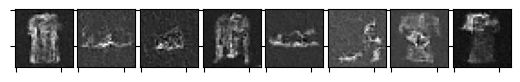

updating best checkpoint
Epoch 2 complete in 9m 21s with total training loss 81.63586714491248


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 3 complete in 8m 42s with total training loss 72.836345911026


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 4 complete in 8m 51s with total training loss 67.27834115922451


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 9.714865382760763
-------- Sampled Images -------


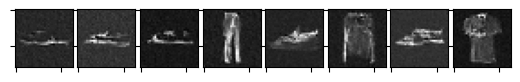

updating best checkpoint
Epoch 5 complete in 9m 23s with total training loss 64.18640406429768


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 6 complete in 8m 41s with total training loss 62.156947653740644


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 7 complete in 8m 42s with total training loss 60.3169593475759


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 9.12963605299592
-------- Sampled Images -------


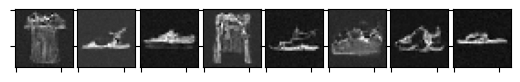

updating best checkpoint
Epoch 8 complete in 9m 21s with total training loss 58.41682992875576


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 9 complete in 9m 3s with total training loss 57.493544444441795


In [39]:
diffusion_model_trainng.train(max_epochs=NUM_EPOCHS,
                            lr = LR,
                            diffusion = diffusion,
                            continue_training=False, continue_path=None,
                            validate_after_k=3,
                            save_after_k=5,
                            plot_after_k=3)

In [42]:
NUM_EPOCHS = 20
LR = 0.00001

CONT_PATH = '/kaggle/working/Version1/best'

The output for current run will be saved at /kaggle/working/Version2


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 9 complete in 8m 43s with total training loss 56.13380525261164


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 10 complete in 8m 49s with total training loss 55.73914918676019


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 8.516637824475765
-------- Sampled Images -------


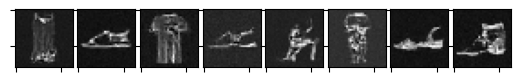

updating best checkpoint
Epoch 11 complete in 9m 30s with total training loss 54.83203772082925


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 12 complete in 8m 48s with total training loss 54.15609597042203


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 13 complete in 8m 44s with total training loss 53.697271924465895


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 8.560803133994341
-------- Sampled Images -------


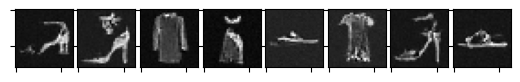

Epoch 14 complete in 9m 9s with total training loss 53.33315056934953


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 15 complete in 8m 26s with total training loss 52.182432137429714


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 16 complete in 8m 26s with total training loss 52.11940222978592


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 8.29916624724865
-------- Sampled Images -------


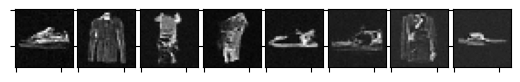

updating best checkpoint
Epoch 17 complete in 9m 10s with total training loss 51.87599116191268


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 18 complete in 8m 36s with total training loss 51.49360369518399


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 19 complete in 8m 40s with total training loss 51.17574252933264


In [43]:
diffusion_model_trainng.train(max_epochs=NUM_EPOCHS,
                            lr = LR,
                            diffusion = diffusion,
                            continue_training=True, continue_path=CONT_PATH,
                            validate_after_k=3,
                            save_after_k=-1,
                            plot_after_k=3)

#### Sample generation

In [51]:
IMG_CHANNELS = 1
IMG_SIZE = 32
sample_ = diffusion.sample(30, IMG_CHANNELS, IMG_SIZE)
type(sample_), sample_.shape, torch.max(sample_), torch.min(sample_)

(torch.Tensor,
 torch.Size([30, 1, 32, 32]),
 tensor(1.1968, device='cuda:0'),
 tensor(-0.2152, device='cuda:0'))

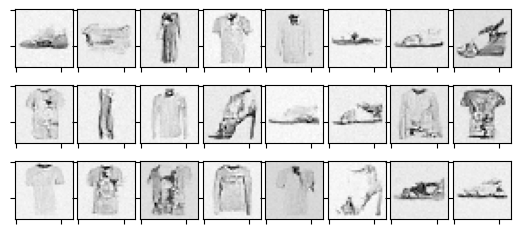

In [53]:
plot_images(1-sample_, display=(3, 8), cmap='gray');

In [40]:
# import shutil
# shutil.rmtree('/kaggle/working/Version0')